In [1]:
import torch
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns

from torch import nn, optim
from torch.nn import Sequential, GRU, Linear, ReLU, Sequential
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

from dataset import EarthSystemsDataset
from nn_util import GrangerRNN, EarthSystemsRNN, GRULayerNorm, Trainer
from util import Timer

In [2]:
sns.__version__

'0.13.0'

## Reccurent Neural Network (RNN)

Defined below are several architectures of RNNs that we experimented with. The most successful was `rnn_layers4`, which was also the simplest. This is because all the other layers ended up overfitting the data which only had ~480 data points.

In [3]:
def rnn_layers1(in_size, label_size, lags):
    # this is a lastonly sequence
    # in_size is number of variables
    h_size1 = 25
    h_size2 = 50
    h_size3 = 80

    rnn_layers = [
        GRU(in_size, h_size1, batch_first=True, num_layers=1),
        GRU(h_size1, h_size2, batch_first=True, num_layers=1),
        GRU(h_size2, h_size3, batch_first=True, num_layers=1)
    ]

    fc_layers = [
        ReLU(),
        Linear(h_size3, label_size)
    ]

    return Sequential(*rnn_layers), Sequential(*fc_layers)

def rnn_layers2(in_size, label_size, lags):
    # this is a lastonly sequence
    # in_size is number of variables
    h_size1 = 50
    h_size2 = 100

    rnn_layers = [
        GRULayerNorm(in_size, h_size1),
        GRULayerNorm(h_size1, h_size2)
    ]


    fc_layers = [
        ReLU(),
        Linear(h_size2, label_size)
    ]

    return Sequential(*rnn_layers), Sequential(*fc_layers)

def rnn_layers3(in_size, label_size, lags):
    # this is a lastonly sequence
    # in_size is number of variables
    h_size1 = 100
    h_size2 = 250

    rnn_layers = [
        GRULayerNorm(in_size, h_size1),
        GRULayerNorm(h_size1, h_size2)
    ]

    fc_layers = [
        ReLU(),
        Linear(h_size2, label_size),
    ]

    return Sequential(*rnn_layers), Sequential(*fc_layers)

def rnn_layers4(in_size, label_size, lags):
    # in_size is number of variables
    # this is a lastonly sequence
    h_size1 = 6
    h_size2 = 12

    rnn_layers = [
        GRULayerNorm(in_size, h_size1),
        GRULayerNorm(h_size1, h_size2)
    ]


    fc_layers = [
        ReLU(),
        Linear(h_size2, label_size)
    ]

    return Sequential(*rnn_layers), Sequential(*fc_layers)

def rnn_layers5(in_size, label_size, lags):
    # in_size is number of variables
    # this is a lastonly sequence
    h_size1 = 25
    h_size2 = 50
    h_size3 = 80
    rnn_layers = [
        GRULayerNorm(in_size, h_size1),
        GRULayerNorm(h_size1, h_size2),
        GRULayerNorm(h_size2, h_size3)
    ]


    fc_layers = [
        ReLU(),
        Linear(h_size3, label_size)
    ]

    return Sequential(*rnn_layers), Sequential(*fc_layers)


def rnn_layers6(in_size, label_size, lags):
    # in_size is number of variables
    # this is a lastonly sequence
    h_size1 = 15
    h_size2 = 30
    h_size3 = 60
    rnn_layers = [
        GRULayerNorm(in_size, h_size1),
        GRULayerNorm(h_size1, h_size2),
        GRULayerNorm(h_size2, h_size3)
    ]


    fc_layers = [
        ReLU(),
        Linear(h_size3, label_size)
    ]

    return Sequential(*rnn_layers), Sequential(*fc_layers)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Finding the best lag value

Finding the ideal number of time lags is essential in time series analysis. However, our program found that the most optimal amount of lags to use was as many as possible. Since we couldn't pass the entire dataset in (i.e. with 483 lags) as a single training point, we picked 30 as a "high enough" number of lags. This struck a balance between improving model performance on training data and determining Granger causality

In [5]:
def find_best_lag(all_lags, k):
    all_var_names = ['global_temp', 'petroleum', 'elec_fossil', 'elec_clean', 'co2', 'ch4']
    y_vals = ['temp_change', 'petroleum', 'elec_fossil', 'elec_clean', 'co2_average', 'ch4_average']

    for yi, y_val in enumerate(y_vals):
        print(f'[{yi+1}/{len(y_vals)}] Finding best lag for y={y_val}')
        for li, lag in enumerate(all_lags):
            timer = Timer()
            print(f'\t[{li+1}/{len(all_lags)}] {k} runs for lag={lag}: ')
            print('\t\t', end='')

            if not os.path.exists(f'logs/lags/{y_val}'):
                os.makedirs(f'logs/lags/{y_val}')

            out = open(f'logs/lags/{y_val}/{y_val}_lag{lag}.out', 'w')
            sys.stdout = out
            
            data = EarthSystemsDataset(all_var_names, y_vals=[y_val], val_frac=0.1, lags=lag, mode='rnn', normalize=True)
            data.train_mode()
            epochs = 250
            errs = []

            # run each model k times to get an average
            for i in range(k):
                sys.stdout = out
                rnn_layers, fc_layers = rnn_layers2(len(all_var_names), 1, lag)
                model = EarthSystemsRNN(rnn_layers, fc_layers, last_only=True).to(device)
                loss_fn = nn.MSELoss()
                optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=5e-3)
            
                trainer = Trainer(model, loss_fn, optimizer, dataset=data, batch_size=10, 
                                  save_path=None, preload=None, device=device, val_freq='epoch')
            
                trainer.run_training(epochs)
                val_err = trainer.get_error('val')
                errs.append(val_err)

                sys.stdout = sys.__stdout__
                print(f'{val_err:.5f}', end=' | ')
                sys.stdout.flush()


            print(f'\n\t\tAvg error: {np.mean(val_err):.5f} (took {timer.get(True):.5f}s)')
            sys.stdout.flush()


## Training
The model `GrangerRNN` predicted for all 6 variables at once, using 6 independent RNNs that each predicted for one variable. In general, the model would overfit the data, however this doesn't matter for our objective since we are not trying to forecast the future. The same model is trained from different random seeds many times in order to find a stable outcome. This is necessary since our dataset is small, meaning that results vary between runs. 

To predict causal relationships between variables, an approach used by Horvath et al, 2022. The approach involves placing a "filtering" layer before the RNN that multiplies each of the 6 variables by a filter. During training, these filters are regularized with L1 regularization to encourage the network to eliminate certain variables. The effect is a network that discards variables that it deems unnecessary to predict; that is, if the filter for series *j* is 0 (or near 0) in a network predicting for series *i*, then we can conclude that series *j* does not Granger cause series *i*.

Below is an example of how we would load and train one of the models.

See the `nn_util.py` file for details about training.

In [7]:
data_var_names = ['global_temp', 'petroleum', 'elec_fossil', 'elec_clean', 'co2', 'ch4']
y_vals = ['temp_change', 'petroleum', 'elec_fossil', 'elec_clean', 'co2_average', 'ch4_average']
lags = 30
lam = 1e-3
lr = 2e-4
preload = 'models/rnn_granger.pth' 
save_path = 'models/rnn_granger.pth'

data = EarthSystemsDataset(data_var_names, y_vals=y_vals, add_index=False, val_frac=0.03, lags=lags, mode='rnn', normalize=True)
data.train_mode()
# rnn_layers, fc_layers = rnn_layers4(len(data_var_names), len(y_vals), lags)

model = GrangerRNN(rnn_layers4, len(y_vals), len(data.data.columns), lags=lags, reg_lags=False, last_only=True).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.NAdam(model.parameters(), lr=lr)

print(f'Using random seed {torch.seed()}')
print(f'LAMBDA={lam}')
trainer = Trainer(model, loss_fn, optimizer, dataset=data, batch_size=16, save_path=save_path, 
                preload=preload, device=device, save_freq=25, val_freq='epoch')

trainer.run_training(250, lam=lam)

Using random seed 844620508178600
LAMBDA=0.001
	Using 15 validation points
	Using 468 training points

TRAINING OVERVIEW
-------------------------------
DATA:

Earth Systems Time Series Data Overview.
Timeframe=monthly for RNN training. Using 30 lags.
Training data: 438 points. Validation data: 15 points (3.0%).
Normalizing data to [0,1]
Variables:
  temp_change: mean=0.40123, std=0.18306
  petroleum: mean=0.75989, std=0.18663
  elec_fossil: mean=0.29484, std=0.22250
  elec_clean: mean=0.34124, std=0.27516
  co2_average: mean=0.45971, std=0.27955
  ch4_average: mean=0.50127, std=0.22218
Predicting for:
  temp_change
  petroleum
  elec_fossil
  elec_clean
  co2_average
  ch4_average
-------------------------------
OPTIMIZER:
 NAdam (
Parameter Group 0
    betas: (0.99, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    lr: 0.0002
    momentum_decay: 0.004
    weight_decay: 0
) 
-------------------------------
LOS

In [8]:
# A training error <0.009 is considered overfit. Overfitting is not ideal, but acceptable for our objective
# A validation error <0.02 is preferred, but again not essential

trainer.get_error('train'), trainer.get_error('val')

(0.002264141832711175, tensor(0.0102, dtype=torch.float64))

# Retrieving Granger Causality

Below, we have code that retrieves the feature filter layer from each model. From our experiments, we find that a filter value >0.01 implies Granger causality. We can then find the average filter from each model.

In [9]:
def get_importances(model_path, data, lags):
    model = GrangerRNN(rnn_layers4, len(y_vals), len(data.data.columns), lags=lags, reg_lags=False, last_only=True).to(device)

    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])

    df_imp = pd.DataFrame(columns=data.data.columns, index=data.data.columns)
    for i in range(len(model.models)):
        df_imp[data.data.columns[i]] = model.models[i].feature_filter.filter.tolist()

    return df_imp

def get_all_importances(model_paths):
    data_var_names = ['global_temp', 'petroleum', 'elec_fossil', 'elec_clean', 'co2', 'ch4']
    y_vals = ['temp_change', 'petroleum', 'elec_fossil', 'elec_clean', 'co2_average', 'ch4_average']
    lags = 30

    data = EarthSystemsDataset(data_var_names, y_vals=y_vals, add_index=True, val_frac=0.03, lags=lags, mode='rnn', normalize=True)
    data.train_mode()

    df_all_imp = pd.DataFrame(columns=['model_num', 'var']+data.data.columns.tolist())

    for model_num, model_path in enumerate(model_paths):
        df_imp = get_importances(model_path, data, lags)
        df_imp['model_num'] = model_num
        df_all_imp = pd.concat([df_all_imp, df_imp.reset_index().rename(columns={'level_0': 'var'})])

    return df_all_imp

def plot_importance_hist(all_imp, indep_var, dep_var):
    vals = all_imp[all_imp['var'] == indep_var][dep_var]

    plt.hist(vals)
    plt.show()


## Plotting predictions

Below are prediction plots for each of the 6 variables . We can see that the training predictions are quite accurate, however the validation forecasts are not. 

In [10]:
data.train_mode()
with torch.no_grad():
    pred_loader = DataLoader(data, batch_size=1, shuffle=False)
    pred = [data.data.reset_index()[y_vals].iloc[0]]*lags \
            + [model(X.to(device, dtype=torch.float)) for X, y in pred_loader]
    _, val_pred = trainer.get_val_error()
    pred = pred + val_pred
pred = torch.tensor(pred)

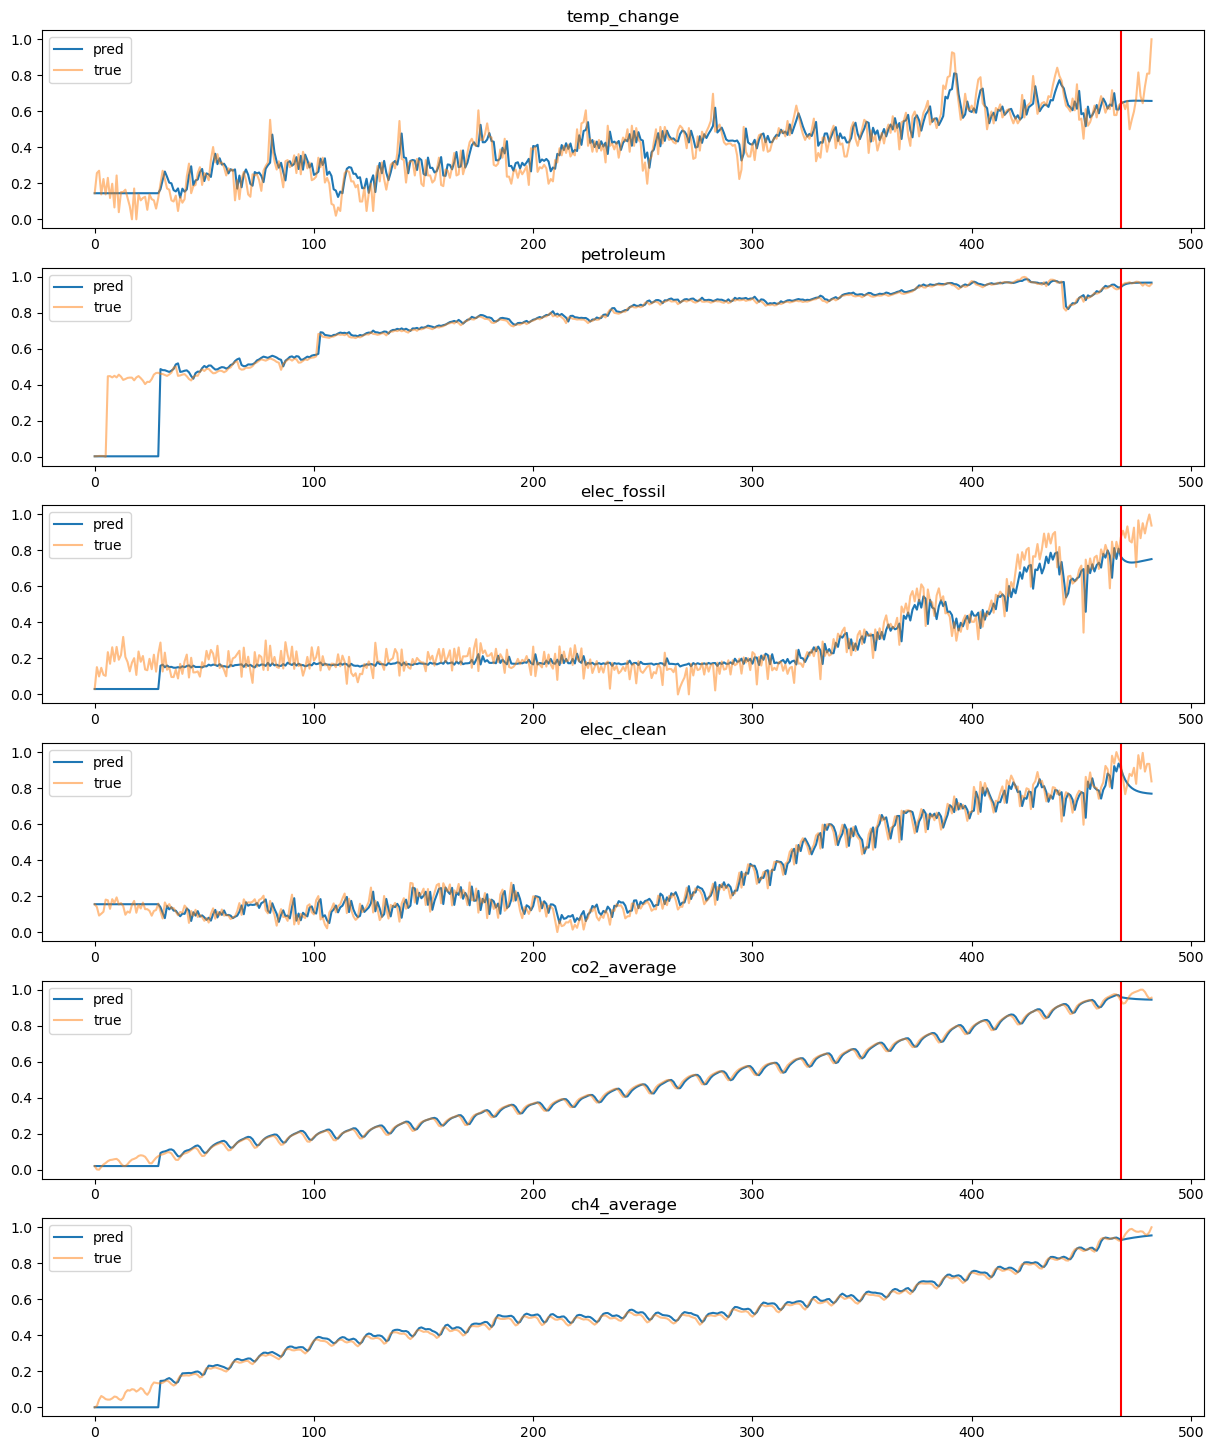

In [11]:
fig, axes = plt.subplots(6, 1, figsize=(15,18))

for i in range(len(axes)):
    
    axes[i].set_title(data.data.columns[i])
    axes[i].plot(pred[:,i], label='pred')
    axes[i].plot(data.full_data.reset_index()[y_vals[i]], alpha=0.5, label='true')
    axes[i].axvline(data.train_data.shape[0], color='red')

    axes[i].legend()

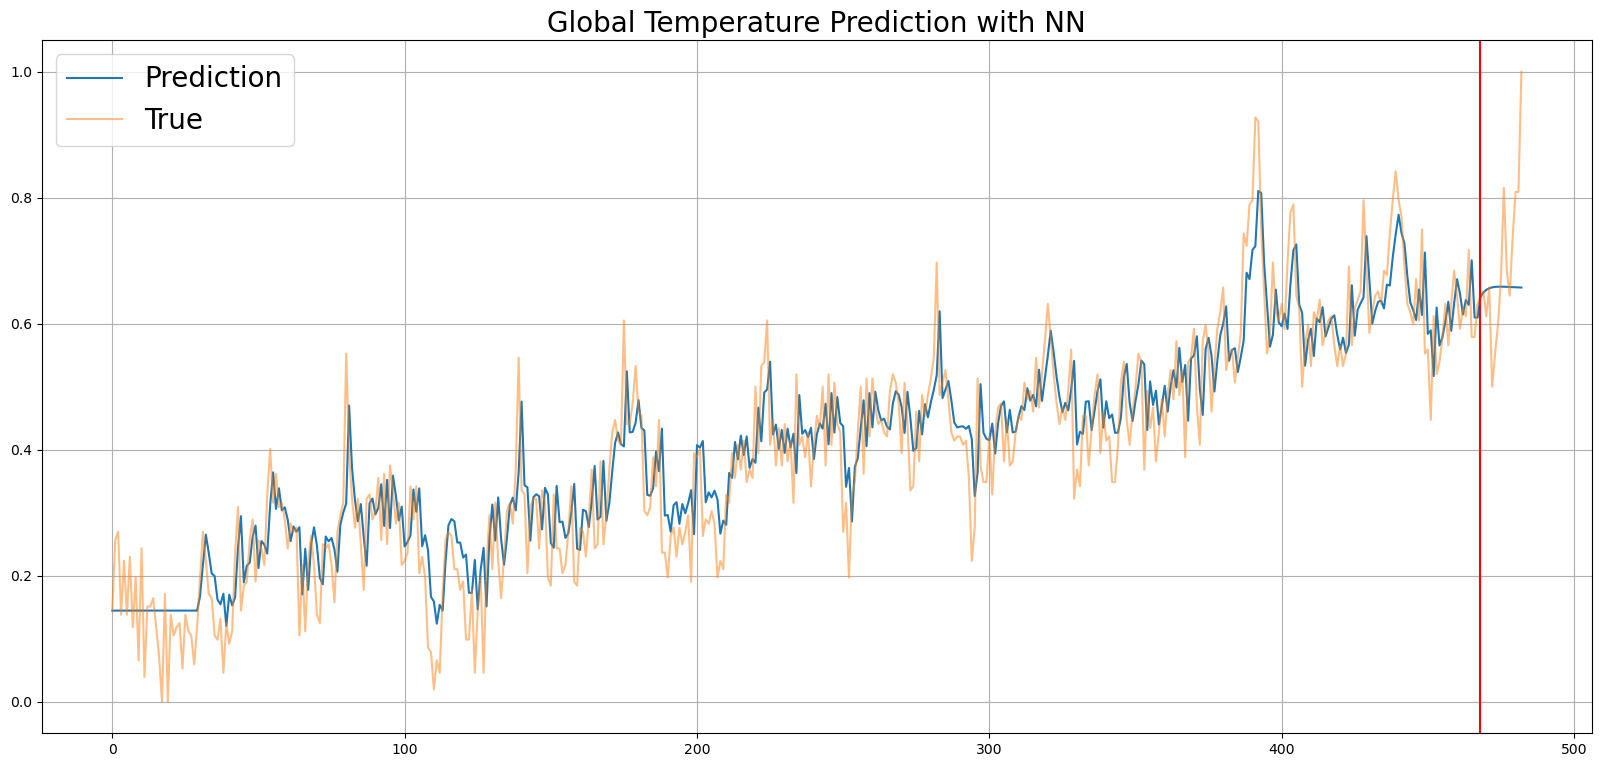

In [49]:
plt.figure(figsize = (20,9))

plt.plot(pred[:,0], label='Prediction')
plt.plot(data.full_data.reset_index()[y_vals[0]], alpha=0.5, label='True')
plt.axvline(data.train_data.shape[0], color='red')
plt.title('Global Temperature Prediction with NN', fontsize = "20")
plt.legend(fontsize = "20")
plt.grid()
plt.show()

Below is a plot of the validation error during training. We can see that it is very unstable, implying an overfit. This further emphasizes the need to train multiple times from scratch.

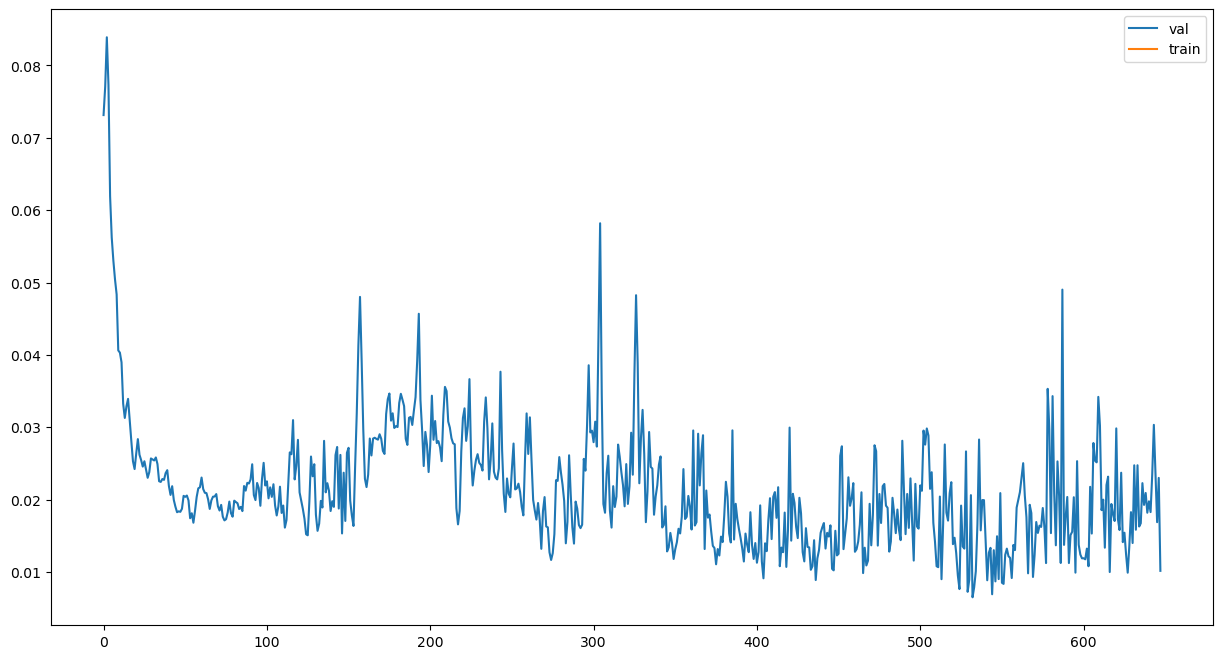

In [12]:
plt.figure(figsize=(15,8))

plt.plot(trainer.val_errors[50:], label='val')
plt.plot(trainer.train_errors, label='train')
plt.legend()

In [13]:
model_paths = [f'models/rnn_granger{i}.pth' for i in range(30)]
all_imp = get_all_importances(model_paths)

In [14]:
df_gc = all_imp.groupby('var').mean().drop(index='index').reindex(['temp_change', 'petroleum', 'elec_fossil', 'elec_clean', 'co2_average', 'ch4_average'])
df_gc

C:\Users\xninj\AppData\Local\Temp\ipykernel_16560\3148703175.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_gc = all_imp.groupby('var').mean().drop(index='index').reindex(['temp_change', 'petroleum', 'elec_fossil', 'elec_clean', 'co2_average', 'ch4_average'])


,temp_change,petroleum,elec_fossil,elec_clean,co2_average,ch4_average
var,,,,,,
temp_change,0.471787,0.000006,0.001028,0.000007,-1.014275e-06,-0.000006
petroleum,0.191047,0.268694,0.264968,0.222638,2.078592e-02,0.076259
elec_fossil,0.001544,0.000001,0.528427,0.000037,-1.143711e-06,0.012301
elec_clean,0.000032,-0.000113,0.317997,0.576593,-6.660880e-08,-0.000010
co2_average,0.102981,0.025865,0.217495,0.234930,2.140660e-01,0.102956
ch4_average,0.073570,0.005667,0.214550,0.062275,1.734973e-02,0.253215


Above, an entry in row `var1` and column `var2` is the filter value that quantifies the importance of `var1` in predicting `var2`. We can see many of these make sense; for example `co2` (0.102), `ch4` (0.073), and `petroleum` (0.191) affect `temp_change` as shown in the first column. However, some entries don't make sense, such as `ch4` and `co2` affecting `elec_fossil` (it should be the other way around, based on prior knowledge). This is likely a spurious correlation, due to external factors not included in this dataset.

In [28]:
poster_names = ['Global Temperature', 
                'Petroleum Production', 
                'Electricity (Fossil Fuels)', 
                'Electricity (Clean)', 
                'Carbon Dioxide',
                'Methane']

In [29]:
df_gc.columns = poster_names

In [30]:
df_gc.index = poster_names

In [31]:
sns.__version__

'0.13.0'

In [32]:
greenmap = sns.light_palette("seagreen", as_cmap=True)

<Axes: >

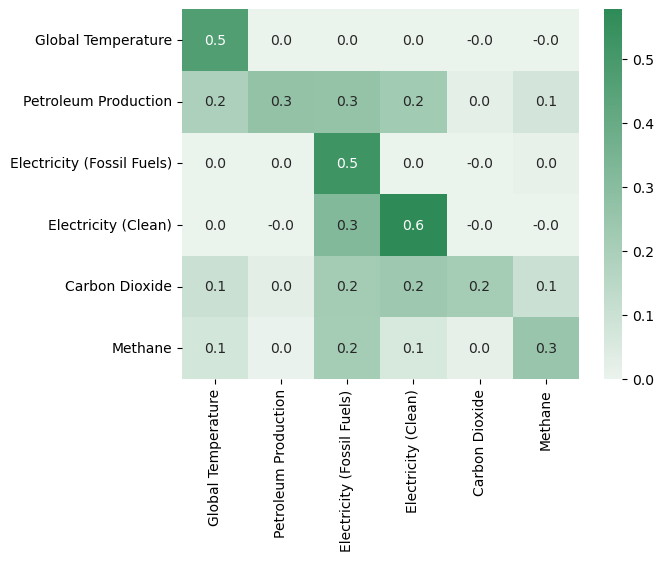

In [33]:
sns.heatmap(df_gc, annot = True, fmt = ".1f", cmap=greenmap)

<Axes: ylabel='var'>

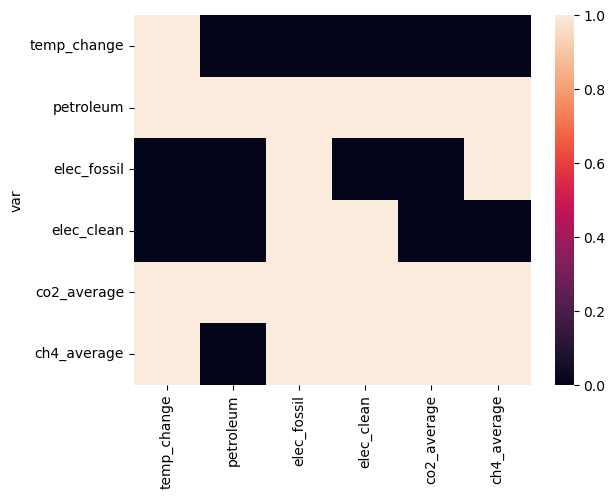

In [14]:
# if we threshold by saying that >0.01 implies Granger causality, we get the following
sns.heatmap(df_gc > 0.01)

In [15]:
data.full_mode()
len(data)

453